**VGG-16 MODEL VALIDATION**

***1. LOADING IMPORTANT LIBRARIES***

In [1]:
import numpy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.utils import save_image


#%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [2]:
## 
## The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, 
## with 6000 images per class. There are 50000 training images and 10000 test images. 
## https://www.cs.toronto.edu/~kriz/cifar.html

tranform_train = transforms.Compose([transforms.Resize((224,224)), transforms.RandomHorizontalFlip(p=0.7), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
tranform_test = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

#preparing the train, validation and test dataset
torch.manual_seed(43)
train_ds = CIFAR10("data/", train=True, download=True, transform=tranform_train) #40,000 original images + transforms
val_size = 10000 #there are 10,000 test images and since there are no transforms performed on the test, we keep the validation as 10,000
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size]) #Extracting the 10,000 validation images from the train set
test_ds = CIFAR10("data/", train=False, download=True, transform=tranform_test) #10,000 images

batch_size = 64

#passing the train, val and test datasets to the dataloader
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [3]:
#***2.1. PREVIEWING THE TRAIN DATASET***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog   deer  dog   truck bird  deer  car   truck dog   deer  frog  dog   frog  plane truck cat   truck horse frog  truck ship  plane cat   ship  ship  horse horse deer  frog  horse cat   frog  cat  


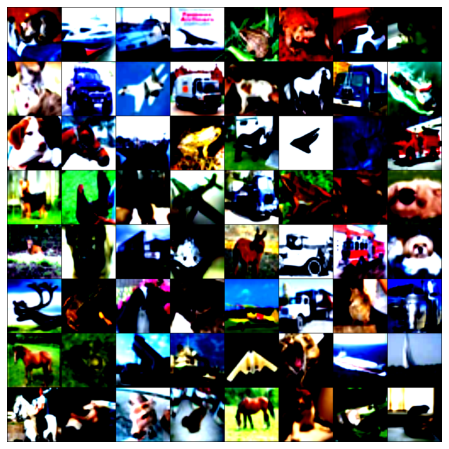

In [4]:
for images_batch, class_labels in test_dl:
    #print(class_labels.size())                 #torch.Size([64])
    #print('images_batch.shape:', images_batch.shape)  #images.shape: torch.Size([64, 3, 224, 224])
    
    print(' '.join(f'{classes[class_labels[j]]:5s}' for j in range(batch_size)))
    
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images_batch).permute((1, 2, 0)))
    break
    
    
    #classes[
    

***3. BUILDING THE MODEL***

In [5]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(25088, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x

***4. PREPARE THE MODEL FOR TRAINING***

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda

print(device)
model = VGG16() #to compile the model
model = model.to(device=device) #to send the model for training on either cuda or cpu

print(model)

## Loss and optimizer
learning_rate = 1e-4 #I picked this because it seems to be the most used by experts
load_model = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate) #Adam seems to be the most popular for deep learning



cuda
VGG16(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_3): Conv2d(51

***5. TRAINING COMMENTED***

In [7]:
# for epoch in range(50): #I decided to train the model for 50 epochs
#     loss_ep = 0
    
#     for batch_idx, (data, targets) in enumerate(train_dl):
#         data = data.to(device=device)
#         targets = targets.to(device=device)
#         ## Forward Pass
#         optimizer.zero_grad()
#         scores = model(data)
#         loss = criterion(scores,targets)
#         loss.backward()
#         optimizer.step()
#         loss_ep += loss.item()
#     print(f"Loss in epoch {epoch} :::: {loss_ep/len(train_dl)}")

#     with torch.no_grad():
#         num_correct = 0
#         num_samples = 0
#         for batch_idx, (data,targets) in enumerate(val_dl):
#             data = data.to(device=device)
#             targets = targets.to(device=device)
#             ## Forward Pass
#             scores = model(data)
#             _, predictions = scores.max(1)
#             num_correct += (predictions == targets).sum()
#             num_samples += predictions.size(0)
#         print(
#             f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
#         )

***6.SAVING THE MODEL AND USING IT FOR THE TEST SET***

In [8]:
#torch.save(model.state_dict(), "vgg16_cifar.pt") #SAVES THE TRAINED MODEL

***6.USING MODEL FOR THE TEST SET***

In [9]:
model = VGG16()
model.load_state_dict(torch.load("vgg16_cifar.pt")) #loads the trained model
model.eval()

VGG16(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_3): Conv2d(512, 51

***7. TESTING***

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda

y_pred_list = []
y_true_list = []
num_correct = 0
num_samples = 0
confusion_matrix = np.zeros([10,10], int)


print (f'len(test_dl) {len(test_dl)}' )
with torch.no_grad():
    for batch_idx, (data,targets) in enumerate(test_dl):
        print(f'   BATCH_INDEX: {batch_idx}')
            
        data = data.to(device=device)
        #print(  data.size()  ) #torch.Size([64, 3, 224, 224])
        targets = targets.to(device=device) #
        #print(  targets.size()  ) #torch.Size([64])
        
        ## Forward Pass
        model = model.to(device=device) #to send the model for training on either cuda or cpu
        scores = model(data)   
        #print(  scores.size()  ) #torch.Size([64, 10])

        #print( scores.max(0) ) print(torch.max(scores, dim = 0)        )
            # values=tensor([18.9992, 10.3248,  3.5991, 15.9880, 18.1045, 20.7815, 24.0002, 39.2279,
            #43.6572, 39.3104], device='cuda:0', grad_fn=<MaxBackward0>),
            #indices=tensor([44,  9, 25,  0, 40, 39, 19, 60, 54, 23], device='cuda:0'))

        #print( scores.max(1) ) # print(torch.max(scores, dim = 1)        )
            #values=tensor([15.9880, 18.5574,  6.1536,  6.7579,  9.2496,  6.6225,  4.8264,  2.8885,
            #15.5634, 10.3248,  1.8525, 30.3759,  8.0254, 27.5736, 29.4389,  5.7232,
            # 9.7512, 11.4322, 27.8614, 24.0002,  8.3870, 17.7756, 11.8143, 39.3104,
            # 8.8894,  3.5991,  8.7150,  8.5406, 15.6594, 23.0119,  9.1206, 13.0630,
            # 8.6765,  5.3555, 22.6181,  6.8813, 11.3729,  8.3588, 16.5485, 20.7815,
            #18.1045, 14.7045,  7.2963, 20.7654, 18.9992, 17.1952,  4.6492,  0.0843,
            #23.7046, 10.3765, 11.0905, 11.6786,  3.2491,  1.6858, 43.6572, 17.3283,
            # 5.8836,  5.8923,  6.8874,  2.6371, 39.2279, 10.2644, 21.2090,  1.1179],
               #device='cuda:0', grad_fn=<MaxBackward0>),
            #indices=tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 6, 5, 7, 8, 6, 7, 0, 4, 9,
            #4, 2, 3, 0, 9, 6, 6, 5, 4, 5, 9, 8, 4, 9, 9, 5, 4, 6, 5, 6, 0, 9, 3, 3,
            #7, 6, 9, 8, 3, 6, 8, 8, 7, 7, 3, 2, 7, 3, 6, 2], device='cuda:0'))


        values, indices_predictions = torch.max(scores, dim = 1)#
        # indices_predictions = torch.max(scores,1)[1]
            #print(indices_predictions)
            #print(f'values: {len(values)}') ## values: 64
            #print(f'indices_predictions: { len(indices_predictions)}') ## indices_predictions: 64
        
        y_pred_list.append(scores.cpu().numpy())
        #print(y_pred_list)
        y_true_list.append(targets.cpu().numpy())
        #print(y_true_list)

        num_correct += (indices_predictions == targets).sum()
        #print(f'   num_correct {num_correct}')
        num_samples += indices_predictions.size(0)
        #print(f'   num_samples {num_samples}')

        
        #for index, label_idx in enumerate(targets):
        for index, label_idx in enumerate(targets):
            #print(label_idx.item())
            #print(indices_predictions[label_idx].item())
            #print(type(index)) #<class 'int'>
            #print(type(label_idx)) #<class 'torch.Tensor'>
            confusion_matrix[label_idx.item(), indices_predictions[index].item()] += 1 
            
print(
    f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
    )

#y_pred_list
#y_true_list

#print( type(y_pred_list) )

# # # # #We’ll flatten out the list so that we can use it as an input to confusion_matrix and classification_report.        
y_pred_list_flatten = [i[0][0] for i in y_pred_list]
y_true_list_flatten = [i[0] for i in y_true_list]        

# #y_pred_list_flatten
# #y_true_list_flatten

print(f'y_pred_list_f{y_pred_list_flatten} LENGTH: {len(y_pred_list_flatten)}  ')
print(f'y_true_list_f{y_true_list_flatten} LENGTH: {len(y_true_list_flatten)}')


len(test_dl) 157
   BATCH_INDEX: 0
   BATCH_INDEX: 1
   BATCH_INDEX: 2
   BATCH_INDEX: 3
   BATCH_INDEX: 4
   BATCH_INDEX: 5
   BATCH_INDEX: 6
   BATCH_INDEX: 7
   BATCH_INDEX: 8
   BATCH_INDEX: 9
   BATCH_INDEX: 10
   BATCH_INDEX: 11
   BATCH_INDEX: 12
   BATCH_INDEX: 13
   BATCH_INDEX: 14
   BATCH_INDEX: 15
   BATCH_INDEX: 16
   BATCH_INDEX: 17
   BATCH_INDEX: 18
   BATCH_INDEX: 19
   BATCH_INDEX: 20
   BATCH_INDEX: 21
   BATCH_INDEX: 22
   BATCH_INDEX: 23
   BATCH_INDEX: 24
   BATCH_INDEX: 25
   BATCH_INDEX: 26
   BATCH_INDEX: 27
   BATCH_INDEX: 28
   BATCH_INDEX: 29
   BATCH_INDEX: 30
   BATCH_INDEX: 31
   BATCH_INDEX: 32
   BATCH_INDEX: 33
   BATCH_INDEX: 34
   BATCH_INDEX: 35
   BATCH_INDEX: 36
   BATCH_INDEX: 37
   BATCH_INDEX: 38
   BATCH_INDEX: 39
   BATCH_INDEX: 40
   BATCH_INDEX: 41
   BATCH_INDEX: 42
   BATCH_INDEX: 43
   BATCH_INDEX: 44
   BATCH_INDEX: 45
   BATCH_INDEX: 46
   BATCH_INDEX: 47
   BATCH_INDEX: 48
   BATCH_INDEX: 49
   BATCH_INDEX: 50
   BATCH_INDEX: 51
   BA

Category   - Accuracy
plane      - 78.0%
car        - 85.6%
bird       - 65.2%
cat        - 62.6%
deer       - 87.1%
dog        - 69.5%
frog       - 85.3%
horse      - 82.6%
ship       - 89.2%
truck      - 86.9%


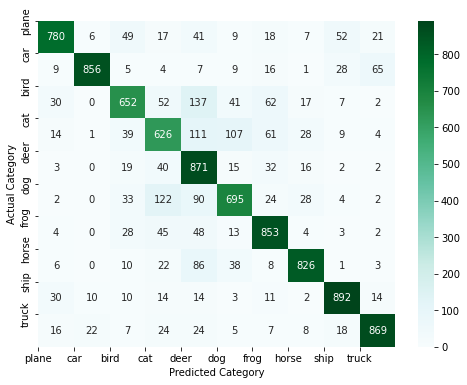

In [11]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}%'.format(classes[i], r[i]/np.sum(r)*100))
    
fig, ax = plt.subplots(1,1,figsize=(8,6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap='BuGn', ax=ax)
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()    

In [12]:
## BLURS
#class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
#classes = ('plane', 'car', 'bird', 'cat',
#           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(y_pred_list_flatten)
print(y_true_list_flatten)

#confusion_matrix(y_true_list_flatten, y_pred_list_flatten)
#print(y_pred_list_flatten.numpy())
# cm = confusion_matrix(targets.view(-1).detach().cpu().numpy(), predicted.view(-1).detach().cpu().numpy())
# print(cm)
# cr = classification_report(targets.view(-1).detach().cpu().numpy(), predicted.view(-1).detach().cpu().numpy())
# print(cr)

# confusion_matrix_df = pd.DataFrame(cm)
# #confusion_matrix_df = pd.DataFrame(cm.rename(columns=class_names, index=class_names))

# fig, ax = plt.subplots(figsize=(7,5))         
# #sns.heatmap(confusion_matrix_df, annot=True)
# sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap='BuGn', ax=ax)
# plt.xlabel("prediction")
# plt.ylabel("label (ground truth)")
# plt.show()





[-14.802964, -19.784279, -8.13194, 0.32332158, -16.124403, -17.423758, -13.857173, -7.1063223, -20.088423, -7.642085, -9.042421, -5.3942895, -14.18315, -7.2376113, -11.763818, -4.796073, -10.721049, -12.815561, 14.206302, -7.0984983, -15.323442, -0.31855905, -9.331572, -15.496964, -14.88394, -3.905265, 13.582698, 3.2741807, -3.6527677, -6.835275, -12.429739, -6.444157, -9.177418, -2.1462858, -16.054367, -6.6072497, -14.982001, 17.84853, -1.7417935, -4.711533, -15.025763, -16.0987, -16.72541, -17.987686, -11.514596, -12.075281, -12.022123, -10.909926, -5.8841906, -13.730594, -5.16015, -1.079661, -13.866307, -2.542736, -12.313423, -11.1827345, -10.40061, -18.533226, -14.47208, -2.9248219, -10.021101, -15.081616, -15.912452, -13.990791, -1.8408922, -30.2945, -6.4843593, -23.878876, -10.915587, -6.241748, -12.613505, -16.953371, -9.56856, -21.47802, -12.931714, -7.755189, -1.2834841, -6.5455437, -13.670136, -3.8130467, -0.84912604, -10.3323965, -5.3760624, -14.124729, -13.008069, -12.80092